# HW8 Part 1: Urban Data VIsualization

Author: Zoe Martiniak (zem232), NYU

Data accessed November 7, 2018

In [1]:
import requests
import os
import sys
import urllib
import pandas as pd
import numpy as np
import geopandas as gp
import pylab as pl
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
!rm *NYCbusinesses.csv*
!rm $PUIDATA/*NYCbusinesses*
url ='https://data.cityofnewyork.us/api/views/w7w3-xahh/rows.csv?accessType=DOWNLOAD'
filename='NYCbusinesses.csv'
urllib.request.urlretrieve(url, filename)
!mv NYCbusinesses.csv $PUIDATA
nycbiz=pd.read_csv(os.getenv('PUIDATA')+ "/" + 'NYCbusinesses.csv')

rm: *NYCbusinesses.csv*: No such file or directory


/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
url2='https://data.cityofnewyork.us/api/views/6bic-qvek/rows.csv?accessType=DOWNLOAD'
urllib.request.urlretrieve(url2, 'DemographicsbyZIP.csv')
!mv DemographicsbyZIP.csv $PUIDATA
zipdemo=pd.read_csv(os.getenv('PUIDATA')+ "/" + 'DemographicsbyZIP.csv')

In [4]:
! rm *'NTA map'*
! rm $PUIDATA/*geo_export*
url = 'https://data.cityofnewyork.us/api/geospatial/d3qk-pfyz?method=export&format=Shapefile'
urllib.request.urlretrieve(url, 'NTA map.zip')
!unzip 'NTA map.zip' -d $PUIDATA
files = ! ls $PUIDATA | grep 'geo_export' | grep '.shp' 
! rm 'NTA map.zip'

rm: *NTA map*: No such file or directory
Archive:  NTA map.zip
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/geo_export_7b476d33-e65d-4137-bb48-99b5b0d93d3a.dbf  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/geo_export_7b476d33-e65d-4137-bb48-99b5b0d93d3a.shp  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/geo_export_7b476d33-e65d-4137-bb48-99b5b0d93d3a.shx  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/geo_export_7b476d33-e65d-4137-bb48-99b5b0d93d3a.prj  


In [5]:
# Making GeoDataFrame of NTA shapfile, & extracting Brooklyn
NTASHP = gp.GeoDataFrame.from_file(os.getenv('PUIDATA') + "/" + files[0])
NTASHP = NTASHP[NTASHP['boroname'] == 'Brooklyn']

In [6]:
cols_to_drop = [i for i in zipdemo.columns.values if i !='JURISDICTION NAME' and i !='COUNT PARTICIPANTS' and i != 'COUNT RECEIVES PUBLIC ASSISTANCE' and i != 'PERCENT RECEIVES PUBLIC ASSISTANCE' and i != 'COUNT NRECEIVES PUBLIC ASSISTANCE'and i !='PERCENT NRECEIVES PUBLIC ASSISTANCE' and i !='COUNT PUBLIC ASSISTANCE UNKNOWN' and i !='PERCENT PUBLIC ASSISTANCE UNKNOWN']
zipdemo.drop(cols_to_drop,axis=1,inplace=True)
zipdemo=zipdemo[zipdemo['COUNT PARTICIPANTS']>0]
zipdemo.rename({'JURISDICTION NAME':'ZIPCODE'},axis=1,inplace=True)

In [7]:
nycbiz.drop(['DCA License Number', 'License Type', 'License Expiration Date', 'License Creation Date', 'Address Building', 'Address Street Name', 'Secondary Address Street Name', 'Address City', 'Address State', 'Contact Phone Number', 'Borough Code', 'BIN', 'BBL'], axis=1, inplace=True)
nycbiz = nycbiz[nycbiz['Longitude'] <0]
## Narrowing search to Brooklyn
nycbiz = nycbiz[nycbiz['Address Borough']=='Brooklyn']
nycbiz['Business Name'].dropna(inplace=True)

In [8]:
affkeys = np.array(list(nycbiz['Business Name'].keys())).astype(int)

In [9]:
d=[(k, nycbiz['NTA'][k]) for k in affkeys if 'DELI' in nycbiz['Business Name'][k] or 'BODEGA' in nycbiz['Business Name'][k]]

In [10]:
g=[(k, nycbiz['NTA'][k]) for k in affkeys if 'GROCER' in nycbiz['Business Name'][k] or 'MARKET' in nycbiz['Business Name'][k] or 'PRODUCE' in nycbiz['Business Name'][k]]


In [11]:
NTA_count = nycbiz.sort_values(['NTA']).groupby(['NTA']).count()
cols_to_drop = [i for i in NTA_count.columns.values if i != 'Business Name']
NTA_count.drop(cols_to_drop, axis=1, inplace=True)

In [12]:
delibiz= pd.DataFrame(d)
delibiz.rename(columns={0:'DELI',1:'NTA'}, inplace=True)
delicount=delibiz.sort_values(['NTA']).groupby(['NTA'])['DELI'].count().reset_index()

In [13]:
grocerybiz= pd.DataFrame(g)
grocerybiz.rename(columns={0:'GROCERY',1:'NTA'}, inplace=True)
grocerycount=grocerybiz.sort_values(['NTA']).groupby(['NTA'])['GROCERY'].count().reset_index()

In [27]:
merged=grocerycount.merge(
    delicount, on='NTA').merge(
    NTASHP, left_on='NTA',right_on='ntacode').merge(
    NTA_count, on='NTA')
merged.set_index('ntaname',inplace=True)

In [28]:
merged['G%'] = merged['GROCERY'] / merged['Business Name']
merged['D%'] = merged['DELI'] / merged['Business Name']

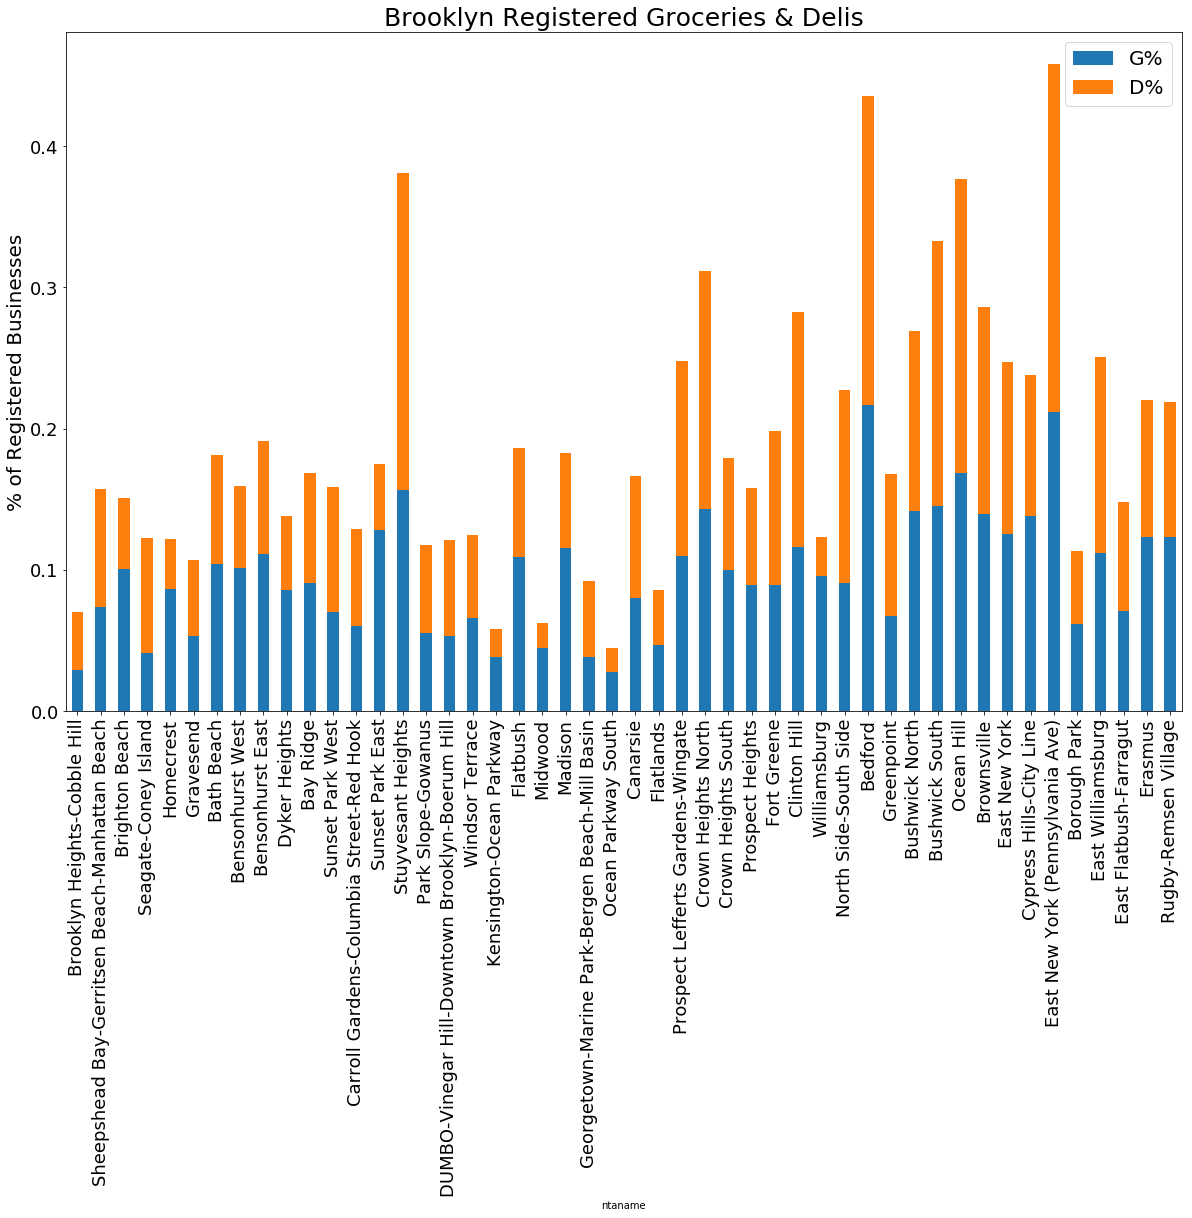

In [49]:
ax=merged[['G%','D%']].plot(kind='bar',stacked=True,figsize=(20,12.5), fontsize=18)
ax.legend(fontsize=20)
ax.set_ylabel("% of Registered Businesses", fontsize=20)
ax.set_title('Brooklyn Registered Groceries & Delis',fontsize=25)
plt.savefig('Groceries&Delis.jpeg') 
plt.show()

In [ ]:
#merged.set_index('ZIPCODE',inplace=True)
ax=merged.plot.bar(fontsize=15, color=('blue','pink'),figsize=(20,12.5))
ax.legend(fontsize=20)
ax.set_xlabel("Neighborhood in Brooklyn (Zip Code)", fontsize=25)
ax.set_ylabel("Registered Businesses", fontsize=25)
ax.set_xticklabels(merged.index.values)
plt.show()

# Total Number of Delis & Groceries In Brooklyn Neighborhoods
This bar graph illustrates the number of delis & groceries in each neighborhood (organized by Zip Code). The total count used for this graphic was determined by selecting registered businesses in NYC with terms relating to 'Deli' or 'Grocery' in the business name; therefore the total count is not considered to be entirely inclusive or accurate. Comparing the availability of convenience stores (delis/bodegas/corner stores/etc.) to grocery stores provides a brief insight into the ease of purchasing healthy foods in these neighborhoods. 


In [ ]:
mergeddemo=merged.merge(zipdemo,on='ZIPCODE')
mergeddemo['Ratio']=mergeddemo['DELI']/merged['GROCERY']

In [ ]:
f, ax = plt.subplots(figsize=(9,9))
Y=mergeddemo['Ratio']
X=mergeddemo['PERCENT RECEIVES PUBLIC ASSISTANCE']
T=Y**6
ax=plt.scatter(X,Y,c=T, alpha=0.5, s=50)
plt.xlabel('% Recieves Public Assistance', size=15)
plt.ylabel('Ratio [Delis/Groceries]',size=15)
plt.title('Availability of Delis/Groceries in Brooklyn ZIPs',size=20)

In [ ]:
gg=[(k, nycbiz['NTA'][k]) for k in affkeys if 'GROCERY' in nycbiz['Business Name'][k] or 'FOOD' in nycbiz['Business Name'][k] or 'PRODUCE' in nycbiz['Business Name'][k] and 'DELI' not in nycbiz['Business Name'][k]]


In [ ]:
dd=[(k, nycbiz['NTA'][k]) for k in affkeys if 'DELI' in nycbiz['Business Name'][k] or 'BODEGA' in nycbiz['Business Name'][k] and 'GROCERY' not in nycbiz['Business Name'][k]]


In [ ]:
dg=[(k, nycbiz['NTA'][k]) for k in affkeys if 'DELI' in nycbiz['Business Name'][k] and 'GROCERY' in nycbiz['Business Name'][k]]

In [ ]:
## deli only dataframe
ddd= pd.DataFrame(dd)
ddd.rename(columns={0:'DELI',1:'NTA'}, inplace=True)
ddd=ddd.groupby(['NTA']).count().reset_index()
## grocery only dataframe
ggg= pd.DataFrame(gg)
ggg.rename(columns={0:'GROCERY',1:'NTA'}, inplace=True)
ggg=ggg.groupby(['NTA']).count().reset_index()
## deli + grocery
dgdg= pd.DataFrame(dg)
dgdg.rename(columns={0:'DELI/GROCERY',1:'NTA'}, inplace=True)
dgdg=dgdg.groupby(['NTA']).count().reset_index()
dgmerged=dgdg.merge(ddd,on='NTA').merge(ggg,on='NTA')
dgmerged=dgmerged[dgmerged.index <48]

In [ ]:
ax=dgmerged.plot.bar(fontsize=15, color=('blue','pink','green'),figsize=(20,13))
ax.legend(fontsize=20)
ax.set_xlabel("Neighborhood in Brooklyn (NTA Code)", fontsize=25)
ax.set_ylabel("Registered Businesses", fontsize=25)
ax.set_xticklabels(dgmerged.NTA.values)
plt.show()

## EXTRA EXTRA: VISUALIZING WITH CHOROPLETHS

In [ ]:
## obtaining PUMA shapefile to visualize Brooklyn
! rm $PUIDATA/*geo*
url = "https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=Shapefile"
urllib.request.urlretrieve(url,'PUMA.zip')
! unzip PUMA.zip -d $PUIDATA
files = ! ls $PUIDATA | grep '.shp'
shapename = files[0]
! rm PUMA.zip

In [ ]:
pumashp=gp.GeoDataFrame.from_file(os.getenv('PUIDATA') + "/" + shapename)
bk=pumashp[pumashp['boro_name']=='Brooklyn']

In [ ]:
bk.rename(columns={'ntacode':'NTA'},inplace=True)

In [ ]:
bkmerged=bk.merge(dgmerged,on='NTA')
bkmerged['Ratio']=bkmerged['DELI']/bkmerged['GROCERY']

In [ ]:
zips=delibiz.merge(zipdemo,on='ZIPCODE')
#zips = zips[zips['COUNT PARTICIPANTS'] >0]
zips=zips.groupby(['NTA'])['PERCENT RECEIVES PUBLIC ASSISTANCE'].mean().reset_index()

In [ ]:
lastmerge=bkmerged.merge(zips ,on='NTA')

In [ ]:
def plot_bk(col, ax):
    """Reusable plotting wrapper."""
    bkmerged.plot(column=col, cmap='Blues',linewidth=0.0, ax=ax)

In [ ]:
f, axarr = plt.subplots(2, 2, figsize=(16, 16))

plt.suptitle('Deli/Grocery Availability & Socio-Economic Standing in Brooklyn Neighborhoods', fontsize=16)
plt.subplots_adjust(top=0.95)

a0=plot_bk('DELI', axarr[0][0])
axarr[0][0].set_title('Delis')

a1=plot_bk('GROCERY', axarr[0][1])
axarr[0][1].set_title('Groceries')

a2=plot_bk('Ratio', axarr[1][0])
axarr[1][0].set_title('Ratio of Delis to Groceries')

a3=lastmerge.plot(column='PERCENT RECEIVES PUBLIC ASSISTANCE', cmap='Blues',linewidth=0.0, ax=axarr[1][1])
axarr[1][1].set_title('% Receiving Public Assistance')

plt.savefig("bk-deli-grocery.png", bbox_inches='tight')

In [ ]:
f, ax = plt.subplots(figsize=(5,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
bkmerged.plot(column='DELI',cmap='Greens',alpha=1,
                  linewidth=0.1,ax=ax, legend=True, k=10)
plt.title("Deli Count", fontsize=20);

f, ax = plt.subplots(figsize=(5,10))
bkmerged.plot(column='GROCERY',cmap='Greens',alpha=1,
                  linewidth=0.1,ax=ax, legend=True, k=10)